
# Ex 8. Monte Carlo Uncertainty Quantification for Water Content Estimation

This example demonstrates Monte Carlo uncertainty quantification for 
converting ERT resistivity models to water content estimates.

The analysis includes:
1. Loading inverted resistivity models from time-lapse ERT
2. Defining parameter distributions for different geological layers
3. Monte Carlo sampling of petrophysical parameters
4. Probabilistic water content estimation with uncertainty bounds
5. Statistical analysis and visualization of results
6. Time series extraction with confidence intervals

Uncertainty quantification is essential for reliable hydrological 
interpretation of geophysical data, providing confidence bounds on
water content estimates and identifying regions of high/low certainty.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pygimli as pg
import sys
from tqdm import tqdm

# Setup package path for development
try:
    # For regular Python scripts
    current_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    # For Jupyter notebooks
    current_dir = os.getcwd()

# Add the parent directory to Python path
parent_dir = os.path.dirname(current_dir)
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Import PyHydroGeophysX modules
from PyHydroGeophysX.petrophysics.resistivity_models import resistivity_to_saturation

# Extract the inverted resistivity values
resistivity_values = np.load("C:/Users/HChen8/Documents/GitHub/PyHydroGeophysX/examples/results/Structure_WC/resmodel.npy")
coverage = np.load("C:/Users/HChen8/Documents/GitHub/PyHydroGeophysX/examples/results/Structure_WC/all_coverage.npy")
# Extract cell markers from the mesh (to identify different geological layers)
cell_markers = np.load("C:/Users/HChen8/Documents/GitHub/PyHydroGeophysX/examples/results/Structure_WC/index_marker.npy")

mesh = pg.load("C:/Users/HChen8/Documents/GitHub/PyHydroGeophysX/examples/results/Structure_WC/mesh_res.bms")

# Number of Monte Carlo realizations
n_realizations = 100

# Set up parameter distributions (means and standard deviations)
# Layer 1 (top layer - marker 3)
layer1_dist = {
    'rhos': {'mean': 100.0, 'std': 20.0},       # Saturated resistivity (ohm-m)
    'n': {'mean': 2.2, 'std': 0.2},             # Saturation exponent
    'sigma_sur': {'mean': 1/500, 'std': 1/2000},  # Surface conductivity (S/m)
    'porosity': {'mean': 0.40, 'std': 0.05}      # Porosity
}

# Layer 2 (bottom layer - marker 2)
layer2_dist = {
    'rhos': {'mean': 500.0, 'std': 100.0},      # Saturated resistivity (ohm-m)
    'n': {'mean': 1.8, 'std': 0.2},             # Saturation exponent
    'sigma_sur': {'mean': 0, 'std': 1/50000},    # Surface conductivity (S/m)
    'porosity': {'mean': 0.35, 'std': 0.1}      # Porosity
}

# Create arrays to store all MC realization results
water_content_all = np.zeros((n_realizations, *resistivity_values.shape))
Saturation_all = np.zeros((n_realizations, *resistivity_values.shape))
# Create arrays to store the parameters used for each realization
params_used = {
    'layer1': {
        'rhos': np.zeros(n_realizations),
        'n': np.zeros(n_realizations),
        'sigma_sur': np.zeros(n_realizations),
        'porosity': np.zeros(n_realizations)
    },
    'layer2': {
        'rhos': np.zeros(n_realizations),
        'n': np.zeros(n_realizations),
        'sigma_sur': np.zeros(n_realizations),
        'porosity': np.zeros(n_realizations)
    }
}

# Perform Monte Carlo simulation
for mc_idx in tqdm(range(n_realizations), desc="Monte Carlo Simulations"):
    # Sample parameters for each layer from their distributions
    # Layer 1
    layer1_params = {
        'rhos': max(1.0, np.random.normal(layer1_dist['rhos']['mean'], layer1_dist['rhos']['std'])),
        'n': max(1.0, np.random.normal(layer1_dist['n']['mean'], layer1_dist['n']['std'])),
        'sigma_sur': max(0.0, np.random.normal(layer1_dist['sigma_sur']['mean'], layer1_dist['sigma_sur']['std']))
    }
    
    # Layer 2
    layer2_params = {
        'rhos': max(1.0, np.random.normal(layer2_dist['rhos']['mean'], layer2_dist['rhos']['std'])),
        'n': max(1.0, np.random.normal(layer2_dist['n']['mean'], layer2_dist['n']['std'])),
        'sigma_sur': max(0.0, np.random.normal(layer2_dist['sigma_sur']['mean'], layer2_dist['sigma_sur']['std']))
    }
    
    # Sample porosity for each layer
    porosity = np.zeros_like(cell_markers, dtype=float)
    layer1_porosity = np.clip(np.random.normal(layer1_dist['porosity']['mean'], 
                                              layer1_dist['porosity']['std']), 0.05, 0.6)
    layer2_porosity = np.clip(np.random.normal(layer2_dist['porosity']['mean'], 
                                              layer2_dist['porosity']['std']), 0.05, 0.6)
    
    porosity[cell_markers == 3] = layer1_porosity  # Top layer porosity
    porosity[cell_markers == 2] = layer2_porosity  # Bottom layer porosity
    
    # Save the parameters used for this realization
    params_used['layer1']['rhos'][mc_idx] = layer1_params['rhos']
    params_used['layer1']['n'][mc_idx] = layer1_params['n']
    params_used['layer1']['sigma_sur'][mc_idx] = layer1_params['sigma_sur']
    params_used['layer1']['porosity'][mc_idx] = layer1_porosity
    
    params_used['layer2']['rhos'][mc_idx] = layer2_params['rhos']
    params_used['layer2']['n'][mc_idx] = layer2_params['n']
    params_used['layer2']['sigma_sur'][mc_idx] = layer2_params['sigma_sur']
    params_used['layer2']['porosity'][mc_idx] = layer2_porosity
    
    # Create arrays to store water content and saturation for this realization
    water_content = np.zeros_like(resistivity_values)
    saturation = np.zeros_like(resistivity_values)
    
    # Process each timestep
    for t in range(resistivity_values.shape[1]):
        # Extract resistivity for this timestep
        resistivity_t = resistivity_values[:, t]
        
        # Process each layer separately
        # Layer 1 (marker 3)
        mask_layer1 = cell_markers == 3
        if np.any(mask_layer1):
            saturation[mask_layer1, t] = resistivity_to_saturation(
                resistivity_t[mask_layer1],
                layer1_params['rhos'],
                layer1_params['n'],
                layer1_params['sigma_sur']
            )
        
        # Layer 2 (marker 2)
        mask_layer2 = cell_markers == 2
        if np.any(mask_layer2):
            saturation[mask_layer2, t] = resistivity_to_saturation(
                resistivity_t[mask_layer2],
                layer2_params['rhos'],
                layer2_params['n'],
                layer2_params['sigma_sur']
            )
        
        # Convert saturation to water content (water_content = saturation * porosity)
        water_content[:, t] = saturation[:, t] * porosity
    
    # Store this realization's water content
    water_content_all[mc_idx] = water_content
    Saturation_all[mc_idx] = saturation

Monte Carlo Simulations:   0%|                                                                                 | 0/100 [00:00<?, ?it/s]

Monte Carlo Simulations:   1%|▋                                                                        | 1/100 [00:03<05:49,  3.53s/it]

Monte Carlo Simulations:   2%|█▍                                                                       | 2/100 [00:07<05:52,  3.59s/it]

Monte Carlo Simulations:   3%|██▏                                                                      | 3/100 [00:10<05:50,  3.61s/it]

Monte Carlo Simulations:   4%|██▉                                                                      | 4/100 [00:14<05:43,  3.58s/it]

Monte Carlo Simulations:   5%|███▋                                                                     | 5/100 [00:18<05:43,  3.61s/it]

Monte Carlo Simulations:   6%|████▍                                                                    | 6/100 [00:21<05:37,  3.59s/it]

Monte Carlo Simulations:   7%|█████                                                                    | 7/100 [00:25<05:31,  3.57s/it]

Monte Carlo Simulations:   8%|█████▊                                                                   | 8/100 [00:28<05:24,  3.52s/it]

Monte Carlo Simulations:   9%|██████▌                                                                  | 9/100 [00:32<05:24,  3.56s/it]

Monte Carlo Simulations:  10%|███████▏                                                                | 10/100 [00:35<05:22,  3.58s/it]

Monte Carlo Simulations:  11%|███████▉                                                                | 11/100 [00:37<04:33,  3.08s/it]

Monte Carlo Simulations:  12%|████████▋                                                               | 12/100 [00:39<04:00,  2.74s/it]

Monte Carlo Simulations:  13%|█████████▎                                                              | 13/100 [00:43<04:19,  2.98s/it]

Monte Carlo Simulations:  14%|██████████                                                              | 14/100 [00:46<04:32,  3.17s/it]

Monte Carlo Simulations:  15%|██████████▊                                                             | 15/100 [00:48<04:00,  2.83s/it]

Monte Carlo Simulations:  16%|███████████▌                                                            | 16/100 [00:50<03:38,  2.60s/it]

Monte Carlo Simulations:  17%|████████████▏                                                           | 17/100 [00:54<04:01,  2.91s/it]

Monte Carlo Simulations:  18%|████████████▉                                                           | 18/100 [00:58<04:17,  3.14s/it]

Monte Carlo Simulations:  19%|█████████████▋                                                          | 19/100 [01:01<04:25,  3.28s/it]

Monte Carlo Simulations:  20%|██████████████▍                                                         | 20/100 [01:03<03:49,  2.87s/it]

Monte Carlo Simulations:  21%|███████████████                                                         | 21/100 [01:05<03:25,  2.60s/it]

Monte Carlo Simulations:  22%|███████████████▊                                                        | 22/100 [01:07<03:10,  2.45s/it]

Monte Carlo Simulations:  23%|████████████████▌                                                       | 23/100 [01:09<02:58,  2.32s/it]

Monte Carlo Simulations:  24%|█████████████████▎                                                      | 24/100 [01:11<02:50,  2.24s/it]

Monte Carlo Simulations:  25%|██████████████████                                                      | 25/100 [01:13<02:43,  2.18s/it]

Monte Carlo Simulations:  26%|██████████████████▋                                                     | 26/100 [01:15<02:37,  2.13s/it]

Monte Carlo Simulations:  27%|███████████████████▍                                                    | 27/100 [01:19<03:08,  2.58s/it]

Monte Carlo Simulations:  28%|████████████████████▏                                                   | 28/100 [01:23<03:28,  2.90s/it]

Monte Carlo Simulations:  29%|████████████████████▉                                                   | 29/100 [01:26<03:40,  3.10s/it]

Monte Carlo Simulations:  30%|█████████████████████▌                                                  | 30/100 [01:28<03:11,  2.74s/it]

Monte Carlo Simulations:  31%|██████████████████████▎                                                 | 31/100 [01:30<02:54,  2.52s/it]

Monte Carlo Simulations:  32%|███████████████████████                                                 | 32/100 [01:32<02:41,  2.38s/it]

Monte Carlo Simulations:  33%|███████████████████████▊                                                | 33/100 [01:36<03:03,  2.74s/it]

Monte Carlo Simulations:  34%|████████████████████████▍                                               | 34/100 [01:38<02:46,  2.52s/it]

Monte Carlo Simulations:  35%|█████████████████████████▏                                              | 35/100 [01:41<03:02,  2.81s/it]

Monte Carlo Simulations:  36%|█████████████████████████▉                                              | 36/100 [01:45<03:10,  2.97s/it]

Monte Carlo Simulations:  37%|██████████████████████████▋                                             | 37/100 [01:47<02:48,  2.67s/it]

Monte Carlo Simulations:  38%|███████████████████████████▎                                            | 38/100 [01:49<02:33,  2.47s/it]

Monte Carlo Simulations:  39%|████████████████████████████                                            | 39/100 [01:51<02:22,  2.33s/it]

Monte Carlo Simulations:  40%|████████████████████████████▊                                           | 40/100 [01:54<02:44,  2.74s/it]

Monte Carlo Simulations:  41%|█████████████████████████████▌                                          | 41/100 [01:58<02:53,  2.95s/it]

Monte Carlo Simulations:  42%|██████████████████████████████▏                                         | 42/100 [02:01<03:03,  3.16s/it]

Monte Carlo Simulations:  43%|██████████████████████████████▉                                         | 43/100 [02:03<02:40,  2.82s/it]

Monte Carlo Simulations:  44%|███████████████████████████████▋                                        | 44/100 [02:05<02:24,  2.58s/it]

Monte Carlo Simulations:  45%|████████████████████████████████▍                                       | 45/100 [02:07<02:10,  2.37s/it]

Monte Carlo Simulations:  46%|█████████████████████████████████                                       | 46/100 [02:11<02:28,  2.75s/it]

Monte Carlo Simulations:  47%|█████████████████████████████████▊                                      | 47/100 [02:15<02:38,  2.99s/it]

Monte Carlo Simulations:  48%|██████████████████████████████████▌                                     | 48/100 [02:17<02:20,  2.70s/it]

Monte Carlo Simulations:  49%|███████████████████████████████████▎                                    | 49/100 [02:18<02:05,  2.46s/it]

Monte Carlo Simulations:  50%|████████████████████████████████████                                    | 50/100 [02:20<01:56,  2.32s/it]

Monte Carlo Simulations:  51%|████████████████████████████████████▋                                   | 51/100 [02:22<01:49,  2.24s/it]

Monte Carlo Simulations:  52%|█████████████████████████████████████▍                                  | 52/100 [02:25<01:44,  2.18s/it]

Monte Carlo Simulations:  53%|██████████████████████████████████████▏                                 | 53/100 [02:27<01:40,  2.14s/it]

Monte Carlo Simulations:  54%|██████████████████████████████████████▉                                 | 54/100 [02:29<01:37,  2.12s/it]

Monte Carlo Simulations:  55%|███████████████████████████████████████▌                                | 55/100 [02:31<01:34,  2.09s/it]

Monte Carlo Simulations:  56%|████████████████████████████████████████▎                               | 56/100 [02:34<01:52,  2.56s/it]

Monte Carlo Simulations:  57%|█████████████████████████████████████████                               | 57/100 [02:36<01:43,  2.41s/it]

Monte Carlo Simulations:  58%|█████████████████████████████████████████▊                              | 58/100 [02:38<01:36,  2.30s/it]

Monte Carlo Simulations:  59%|██████████████████████████████████████████▍                             | 59/100 [02:42<01:50,  2.70s/it]

Monte Carlo Simulations:  60%|███████████████████████████████████████████▏                            | 60/100 [02:46<01:59,  2.99s/it]

Monte Carlo Simulations:  61%|███████████████████████████████████████████▉                            | 61/100 [02:48<01:44,  2.69s/it]

Monte Carlo Simulations:  62%|████████████████████████████████████████████▋                           | 62/100 [02:50<01:33,  2.47s/it]

Monte Carlo Simulations:  63%|█████████████████████████████████████████████▎                          | 63/100 [02:52<01:26,  2.34s/it]

Monte Carlo Simulations:  64%|██████████████████████████████████████████████                          | 64/100 [02:55<01:36,  2.68s/it]

Monte Carlo Simulations:  65%|██████████████████████████████████████████████▊                         | 65/100 [02:57<01:26,  2.48s/it]

Monte Carlo Simulations:  66%|███████████████████████████████████████████████▌                        | 66/100 [02:59<01:19,  2.34s/it]

Monte Carlo Simulations:  67%|████████████████████████████████████████████████▏                       | 67/100 [03:01<01:13,  2.24s/it]

Monte Carlo Simulations:  68%|████████████████████████████████████████████████▉                       | 68/100 [03:05<01:23,  2.60s/it]

Monte Carlo Simulations:  69%|█████████████████████████████████████████████████▋                      | 69/100 [03:08<01:28,  2.87s/it]

Monte Carlo Simulations:  70%|██████████████████████████████████████████████████▍                     | 70/100 [03:12<01:31,  3.06s/it]

Monte Carlo Simulations:  71%|███████████████████████████████████████████████████                     | 71/100 [03:15<01:33,  3.22s/it]

Monte Carlo Simulations:  72%|███████████████████████████████████████████████████▊                    | 72/100 [03:17<01:19,  2.84s/it]

Monte Carlo Simulations:  73%|████████████████████████████████████████████████████▌                   | 73/100 [03:19<01:09,  2.57s/it]

Monte Carlo Simulations:  74%|█████████████████████████████████████████████████████▎                  | 74/100 [03:21<01:02,  2.41s/it]

Monte Carlo Simulations:  75%|██████████████████████████████████████████████████████                  | 75/100 [03:23<00:57,  2.31s/it]

Monte Carlo Simulations:  76%|██████████████████████████████████████████████████████▋                 | 76/100 [03:27<01:05,  2.72s/it]

Monte Carlo Simulations:  77%|███████████████████████████████████████████████████████▍                | 77/100 [03:30<01:07,  2.95s/it]

Monte Carlo Simulations:  78%|████████████████████████████████████████████████████████▏               | 78/100 [03:32<00:58,  2.67s/it]

Monte Carlo Simulations:  79%|████████████████████████████████████████████████████████▉               | 79/100 [03:36<01:01,  2.91s/it]

Monte Carlo Simulations:  80%|█████████████████████████████████████████████████████████▌              | 80/100 [03:40<01:02,  3.13s/it]

Monte Carlo Simulations:  81%|██████████████████████████████████████████████████████████▎             | 81/100 [03:41<00:52,  2.76s/it]

Monte Carlo Simulations:  82%|███████████████████████████████████████████████████████████             | 82/100 [03:43<00:45,  2.54s/it]

Monte Carlo Simulations:  83%|███████████████████████████████████████████████████████████▊            | 83/100 [03:47<00:48,  2.85s/it]

Monte Carlo Simulations:  84%|████████████████████████████████████████████████████████████▍           | 84/100 [03:49<00:41,  2.61s/it]

Monte Carlo Simulations:  85%|█████████████████████████████████████████████████████████████▏          | 85/100 [03:51<00:36,  2.42s/it]

Monte Carlo Simulations:  86%|█████████████████████████████████████████████████████████████▉          | 86/100 [03:55<00:38,  2.75s/it]

Monte Carlo Simulations:  87%|██████████████████████████████████████████████████████████████▋         | 87/100 [03:58<00:38,  2.97s/it]

Monte Carlo Simulations:  88%|███████████████████████████████████████████████████████████████▎        | 88/100 [04:01<00:36,  3.07s/it]

Monte Carlo Simulations:  89%|████████████████████████████████████████████████████████████████        | 89/100 [04:05<00:35,  3.26s/it]

Monte Carlo Simulations:  90%|████████████████████████████████████████████████████████████████▊       | 90/100 [04:09<00:33,  3.35s/it]

Monte Carlo Simulations:  91%|█████████████████████████████████████████████████████████████████▌      | 91/100 [04:12<00:30,  3.42s/it]

Monte Carlo Simulations:  92%|██████████████████████████████████████████████████████████████████▏     | 92/100 [04:16<00:27,  3.39s/it]

Monte Carlo Simulations:  93%|██████████████████████████████████████████████████████████████████▉     | 93/100 [04:18<00:20,  2.98s/it]

Monte Carlo Simulations:  94%|███████████████████████████████████████████████████████████████████▋    | 94/100 [04:20<00:16,  2.67s/it]

Monte Carlo Simulations:  95%|████████████████████████████████████████████████████████████████████▍   | 95/100 [04:21<00:12,  2.43s/it]

Monte Carlo Simulations:  96%|█████████████████████████████████████████████████████████████████████   | 96/100 [04:23<00:09,  2.31s/it]

Monte Carlo Simulations:  97%|█████████████████████████████████████████████████████████████████████▊  | 97/100 [04:26<00:06,  2.24s/it]

Monte Carlo Simulations:  98%|██████████████████████████████████████████████████████████████████████▌ | 98/100 [04:28<00:04,  2.20s/it]

Monte Carlo Simulations:  99%|███████████████████████████████████████████████████████████████████████▎| 99/100 [04:30<00:02,  2.12s/it]

Monte Carlo Simulations: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [04:31<00:00,  2.07s/it]

Monte Carlo Simulations: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [04:31<00:00,  2.72s/it]

Calculate statistics across all realizations



In [2]:
water_content_mean = np.mean(water_content_all, axis=0)
water_content_std = np.std(water_content_all, axis=0)
water_content_p10 = np.percentile(water_content_all, 10, axis=0)  # 10th percentile
water_content_p50 = np.percentile(water_content_all, 50, axis=0)  # Median
water_content_p90 = np.percentile(water_content_all, 90, axis=0)  # 90th percentile

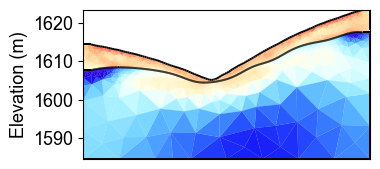

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\HChen8\\Documents\\GitHub\\PyHydroGeophysX\\docs\\source\\auto_examples\\results\\Structure_WC\\timelapse_sat.tiff'

<Figure size 640x480 with 0 Axes>

In [3]:
from palettable.lightbartlein.diverging import BlueDarkRed18_18_r
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pylab as pylab
params = {'legend.fontsize': 13,
          #'figure.figsize': (15, 5),
         'axes.labelsize': 13,
         'axes.titlesize':13,
         'xtick.labelsize':13,
         'ytick.labelsize':13}

pylab.rcParams.update(params)
plt.rcParams["font.family"] = "Arial"

fixed_cmap = BlueDarkRed18_18_r.mpl_colormap
fig = plt.figure(figsize=[16, 6])

# Use tight_layout with adjusted parameters to reduce space
plt.subplots_adjust(wspace=0.05, hspace=0.05)

# True resistivity model
for i in range(12):
    row, col = i // 4, i % 4
    ax = fig.add_subplot(3, 4, i+1)
    
    # Add common ylabel only to leftmost panels
    ylabel = "Elevation (m)" if col == 0 else None
    
    # Add resistivity label only to the middle-right panel (row 1, col 3)
    resistivity_label = ' Resistivity ($\Omega$ m)' if (i == 7) else None
    
    # Only show axis ticks on leftmost and bottom panels
    if col != 0:
        ax.set_yticks([])
    
    if row != 2:  # Not bottom row
        ax.set_xticks([])
    else:
        # Add "distance (m)" label to bottom row panels
        ax.set_xlabel("Distance (m)")
    
    # Create the plot
    ax, cbar = pg.show(mesh,
                      water_content_mean[:, i],
                      pad=0.3,
                      orientation="vertical",
                      cMap=fixed_cmap,
                      cMin=0,
                      cMax=0.32,
                      ylabel=ylabel,
                      label= 'Water Content (-)',
                      ax=ax,
                      logScale=False,
                      coverage=coverage[i,:]>-1.2)
    
    # Only keep colorbar for the middle-right panel (row 1, col 3)
    # This corresponds to panel index 7 in a 0-based indexing system
    if i != 7:  # Keep only the colorbar for panel 7
        cbar.remove()

plt.tight_layout()
plt.savefig("results/Structure_WC/timelapse_sat.tiff", dpi=300, bbox_inches='tight')

In [4]:
WC_true = []

for i in np.arange(30,361,30):
    # Extract true water content values for the current timestep
    true_values = np.load("results/TL_measurements/synwcmodel/synwcmodel"+str(i)+".npy")
      
    # Store the true values for this timestep
    WC_true.append(true_values)
mesh_true = pg.load("results/TL_measurements/mesh.bms")
WC_true = np.array(WC_true)
print(WC_true.shape)

FileNotFoundError: [Errno 2] No such file or directory: 'results/TL_measurements/synwcmodel/synwcmodel30.npy'

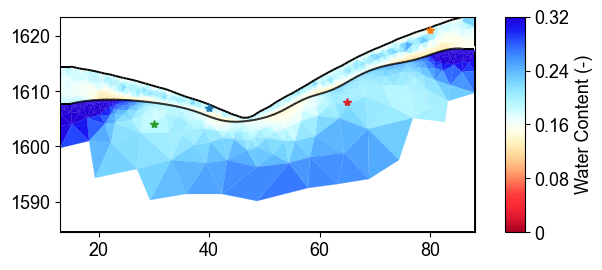

In [5]:
fig = plt.figure(figsize=[6, 3])
ax = fig.add_subplot(1, 1, 1)
ax, cbar = pg.show(mesh,
                water_content_mean[:, 6],
                pad=0.3,
                orientation="vertical",
                cMap=fixed_cmap,
                cMin=0,
                cMax=0.32,
                ylabel=ylabel,
                label= 'Water Content (-)',
                ax=ax,
                logScale=False,
                coverage=coverage[6,:]>-1.2)

ax.plot([40],[1607],'*')
ax.plot([80],[1621],'*')

ax.plot([30],[1604],'*')
ax.plot([65],[1608],'*')

Modified function to extract time series based on x AND y positions



In [6]:
def extract_mc_time_series(mesh, values_all, positions):
    """
    Extract Monte Carlo time series at specific x,y positions
    
    Args:
        mesh: PyGIMLI mesh
        values_all: Array of all Monte Carlo realizations (n_realizations, n_cells, n_timesteps)
        positions: List of (x,y) coordinate tuples
        
    Returns:
        time_series: Array of shape (n_positions, n_realizations, n_timesteps)
        cell_indices: List of cell indices corresponding to the positions
    """
    n_realizations = values_all.shape[0]
    n_timesteps = values_all.shape[2]
    
    # Find indices of cells closest to specified positions
    cell_indices = []
    for x_pos, y_pos in positions:
        # Calculate distance from each cell center to the position
        cell_centers = np.array(mesh.cellCenters())
        distances = np.sqrt((cell_centers[:, 0] - x_pos)**2 + (cell_centers[:, 1] - y_pos)**2)
        cell_idx = np.argmin(distances)
        cell_indices.append(cell_idx)
    
    # Extract time series for each realization and position
    time_series = np.zeros((len(positions), n_realizations, n_timesteps))
    
    for pos_idx, cell_idx in enumerate(cell_indices):
        for mc_idx in range(n_realizations):
            time_series[pos_idx, mc_idx, :] = values_all[mc_idx, cell_idx, :]
    
    return time_series, cell_indices


def extract_true_values_at_positions(mesh, true_values, positions):
    """
    Extract true water content values at specific x,y positions.
    
    Args:
        mesh: PyGIMLI mesh
        true_values: Array of true water content values (n_cells, n_timesteps) or (n_cells,)
        positions: List of (x,y) coordinate tuples
        
    Returns:
        true_values_at_positions: Values at each position
        cell_indices: List of cell indices corresponding to the positions
    """
    # Find indices of cells closest to specified positions
    cell_indices = []
    for x_pos, y_pos in positions:
        # Calculate distance from each cell center to the position
        cell_centers = np.array(mesh.cellCenters())
        distances = np.sqrt((cell_centers[:, 0] - x_pos)**2 + (cell_centers[:, 1] - y_pos)**2)
        cell_idx = np.argmin(distances)
        cell_indices.append(cell_idx)
    
    # Extract true values at the specified positions
    if true_values.ndim == 1:  # Single value per cell
        true_values_at_positions = true_values[cell_indices]
    elif true_values.ndim == 2:  # Time series per cell
        true_values_at_positions = true_values[cell_indices, :]
    else:
        raise ValueError("Unexpected shape for true_values")
    
    return true_values_at_positions, cell_indices

In [7]:
# Define positions to sample (x,y coordinates)
positions = [
    (80, 1621),  # Example coordinates, adjust based on your model
    (40, 1607),
]

# Extract time series data for these positions
time_series_data, cell_indices = extract_mc_time_series(mesh, water_content_all, positions)
Pos1_true, _ = extract_true_values_at_positions(mesh_true, WC_true.T, positions)
Pos1_true

NameError: name 'mesh_true' is not defined

Plot time series with uncertainty bands



NameError: name 'Pos1_true' is not defined

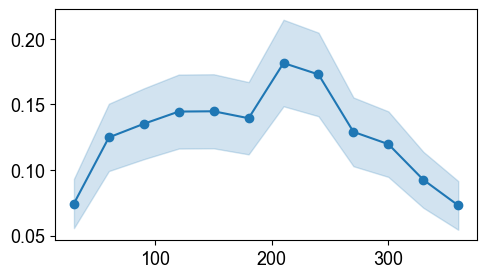

In [8]:
plt.figure(figsize=(12, 3))

measurement_times = np.arange(30,361,30)  # Assuming sequential timesteps


# Calculate statistics
mean_ts = np.mean(time_series_data[0], axis=0)
std_ts = np.std(time_series_data[0], axis=0)

plt.subplot(1, 2, 1)
plt.plot(measurement_times, mean_ts, 'o-', color='tab:blue', label='Estimated')
plt.fill_between(measurement_times, mean_ts-std_ts, mean_ts+std_ts, color='tab:blue', alpha=0.2)
plt.plot(measurement_times,Pos1_true[0, :], 'tab:blue',ls='--', label='True')
plt.grid(True)
plt.legend(frameon=False)
plt.xlabel('Time (Days)')
plt.ylabel('Water Content (-)')
plt.ylim(0, 0.35)
plt.subplot(1, 2, 2)
mean_ts = np.mean(time_series_data[1], axis=0)
std_ts = np.std(time_series_data[1], axis=0)
plt.plot(measurement_times, mean_ts, 'o-', color='tab:blue',)
plt.fill_between(measurement_times, mean_ts-std_ts, mean_ts+std_ts, color='tab:blue', alpha=0.2)
plt.plot(measurement_times,Pos1_true[1, :], 'tab:blue',ls='--')
plt.xlabel('Time (Days)')
plt.ylabel('Water Content (-)')
plt.ylim(0, 0.35)
# plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("results/Structure_WC/regolith_WC.tiff", dpi=300, bbox_inches='tight')

Fractured bedrock layer



In [9]:
# Define positions to sample (x,y coordinates)
positions = [
    (30, 1604),  # Example coordinates, adjust based on your model
    (65, 1608),
]

# Extract time series data for these positions
time_series_data2, cell_indices = extract_mc_time_series(mesh, water_content_all, positions)
Pos2_true, _ = extract_true_values_at_positions(mesh_true, WC_true.T, positions)
Pos2_true

NameError: name 'mesh_true' is not defined

Plot time series with uncertainty bands



NameError: name 'Pos2_true' is not defined

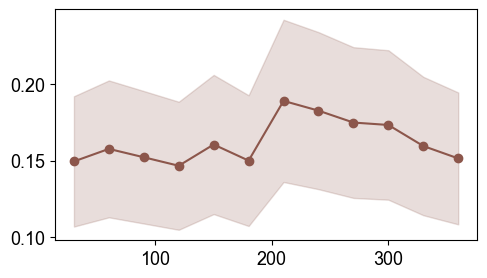

In [10]:
plt.figure(figsize=(12, 3))

measurement_times = np.arange(30,361,30)  # Assuming sequential timesteps


# Calculate statistics
mean_ts = np.mean(time_series_data2[0], axis=0)
std_ts = np.std(time_series_data2[0], axis=0)

plt.subplot(1, 2, 1)
plt.plot(measurement_times, mean_ts, 'o-', color='tab:brown', label='Estimated')
plt.fill_between(measurement_times, mean_ts-std_ts, mean_ts+std_ts, color='tab:brown', alpha=0.2)
plt.plot(measurement_times,Pos2_true[0, :], 'tab:brown',ls='--', label='True')
plt.grid(True)
#plt.legend(frameon=False)
plt.xlabel('Time (Days)')
plt.ylabel('Water Content (-)')
plt.ylim(0, 0.35)
plt.subplot(1, 2, 2)
mean_ts = np.mean(time_series_data2[1], axis=0)
std_ts = np.std(time_series_data2[1], axis=0)
plt.plot(measurement_times, mean_ts, 'o-', color='tab:brown',)
plt.fill_between(measurement_times, mean_ts-std_ts, mean_ts+std_ts, color='tab:brown', alpha=0.2)
plt.plot(measurement_times,Pos2_true[1, :], 'tab:brown',ls='--')
plt.xlabel('Time (Days)')
plt.ylabel('Water Content (-)')
plt.ylim(0, 0.35)
# plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig("results/Structure_WC/Fracture_WC.tiff", dpi=300, bbox_inches='tight')